In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset

from energy_datasets.spain_energy_weather import sp_energy_loader as sp


In [15]:
class MainConfig:
    context_length = 12
    lags_sequence = [1, 2, 3, 4, 5, 6, 7]
    prediction_length = 14
    wandb = False
    train_batch_size = 8
    valid_batch_size = 16
    lr = 5e-3
    epochs = 20#50
    device = "cuda" if torch.cuda.is_available() else "cpu"


In [16]:
"""Extracting data"""
df = sp.get_raw_dataframe()#drop_cols=['time_features'])
df = sp.proc_dataframe_dates(df)

# Filter features/covariates to train on -- for example if training on multi-year data, maybe include year
df = df#[['price actual', 'week', 'hour']]

df

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,year,week,hour
0,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41,0.995553,0.019231,0
1,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92,0.995553,0.019231,1
2,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48,0.995553,0.019231,2
3,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32,0.995553,0.019231,3
4,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04,0.995553,0.019231,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34988,317.0,718.0,9149.0,2931.0,294.0,1.0,1167.0,3144.0,6074.0,60.0,...,6151.0,28.0,6063.0,32291.0,32642.0,66.00,73.60,0.997036,1.000000,20
34989,317.0,675.0,8024.0,2889.0,294.0,1.0,1156.0,2525.0,6075.0,61.0,...,6461.0,20.0,6361.0,31778.0,32155.0,62.09,69.21,0.997036,1.000000,21
34990,301.0,569.0,6871.0,2871.0,291.0,57.0,1181.0,1741.0,6075.0,60.0,...,6871.0,18.0,6456.0,30037.0,30428.0,61.77,67.53,0.997036,1.000000,22
34991,305.0,310.0,5822.0,2619.0,288.0,186.0,1166.0,1426.0,6075.0,61.0,...,7062.0,15.0,6627.0,27439.0,28015.0,58.43,64.08,0.997036,1.000000,23


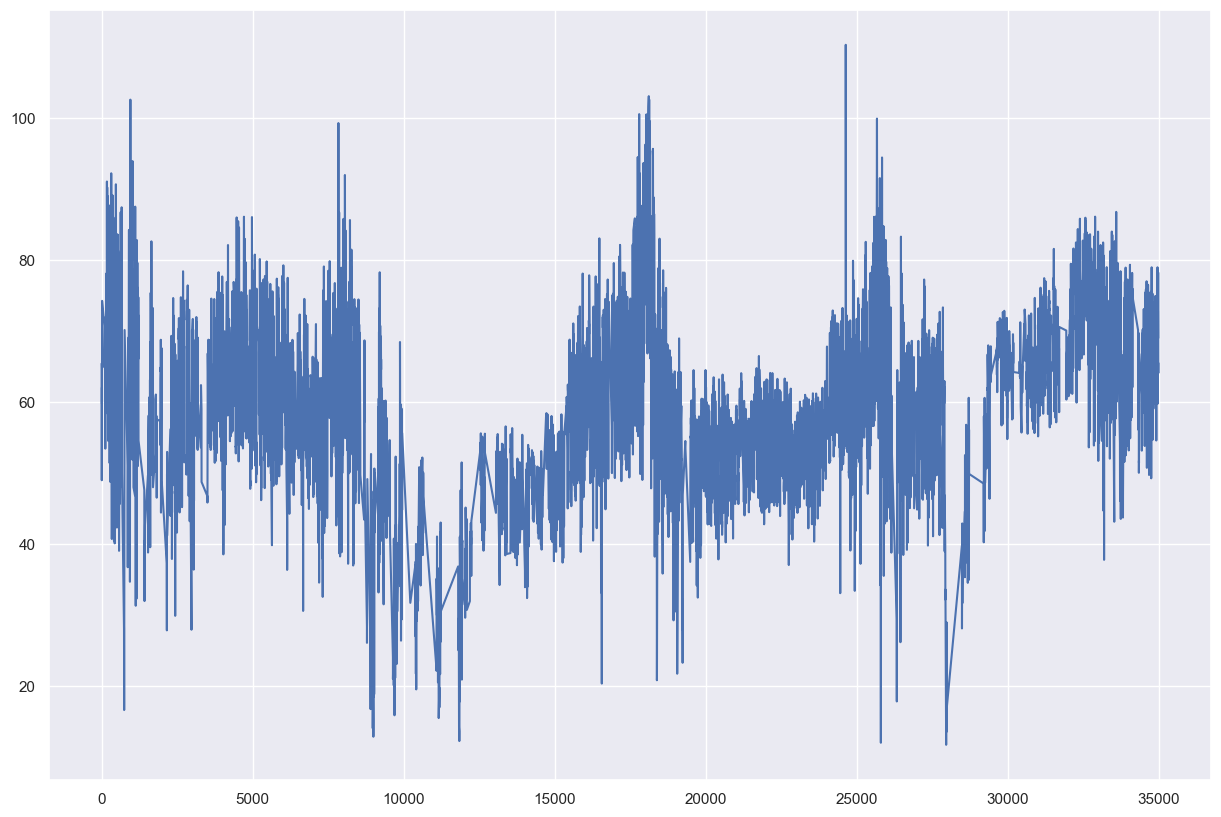

In [17]:
"""Check data"""
sns.set_theme()
plt.figure(figsize= (15, 10))
plt.plot(df['price actual'])
plt.show()

In [18]:
scales = {col : MinMaxScaler(feature_range=(-1, 1)) for col in df.columns}

df_scaled = df
for col in df_scaled.columns:
    df_scaled[col] = scales[col].fit_transform(df_scaled[col].values.reshape(-1, 1))

df_scaled
df = df_scaled
df_scaled

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,year,week,hour
0,0.304556,-0.341365,-0.654360,0.078468,-0.696970,-0.609955,-0.04250,-0.618585,0.987207,-0.235294,...,-0.198434,-0.994372,-0.187282,-0.278718,-0.346483,-0.032314,0.088992,-1.0,-1.000000,-1.000000
1,0.314149,-0.343373,-0.598703,0.060793,-0.721212,-0.584163,-0.09500,-0.670665,0.987207,-0.235294,...,-0.262100,-0.994724,-0.263483,-0.389068,-0.437446,-0.075689,0.079059,-1.0,-1.000000,-0.913043
2,0.309353,-0.353414,-0.652305,0.014194,-0.727273,-0.473756,-0.14000,-0.732685,0.989034,-0.235294,...,-0.318069,-0.997538,-0.316298,-0.521320,-0.586904,-0.092388,0.070140,-1.0,-1.000000,-0.826087
3,0.261391,-0.491968,-0.738161,-0.106320,-0.709091,-0.320362,-0.17000,-0.860616,0.988425,-0.235294,...,-0.347162,-0.999648,-0.356106,-0.602684,-0.718224,-0.202125,-0.034462,-1.0,-1.000000,-0.739130
4,0.213429,-0.626506,-0.767254,-0.184253,-0.733333,-0.174208,-0.16500,-0.873366,0.987816,-0.235294,...,-0.386693,-0.997186,-0.394206,-0.682557,-0.810910,-0.285838,-0.100953,-1.0,-1.000000,-0.652174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34988,-0.318945,0.439759,0.026326,-0.427691,0.103030,-1.000000,0.10250,-0.349541,0.364606,0.098039,...,-0.228050,-0.990503,-0.236287,0.296612,0.311658,0.312514,0.255017,1.0,0.961538,0.739130
34989,-0.318945,0.353414,-0.151553,-0.438939,0.103030,-1.000000,0.08875,-0.483306,0.365215,0.117647,...,-0.187606,-0.993317,-0.197136,0.248800,0.267492,0.227716,0.166025,1.0,0.961538,0.826087
34990,-0.395683,0.140562,-0.333860,-0.443760,0.084848,-0.974661,0.12000,-0.652728,0.365215,0.098039,...,-0.134116,-0.994020,-0.184655,0.086537,0.110869,0.220776,0.131968,1.0,0.961538,0.913043
34991,-0.376499,-0.379518,-0.499723,-0.511248,0.066667,-0.916290,0.10125,-0.720800,0.365215,0.117647,...,-0.109198,-0.995076,-0.162189,-0.155599,-0.107967,0.148341,0.062031,1.0,0.961538,1.000000


In [ ]:
def get_rolling_window(df:pd.DataFrame, context_length=None, predict_length=None, win_size=None, format='list'):#, return_dict=False):
    """Window Splitting"""
    if win_size is None:
        win_size = context_length + predict_length
    rolling_bins = df.rolling(window=(win_size), closed='left')

    if format=='dataframe':
        return [s for s in rolling_bins][win_size:]

    if format=='dict':
        return [s.to_dict(orient='list') for s in (rolling_bins)][win_size:]
    
    rolling_bins = [list(s.values) for s in (rolling_bins)][win_size:]

    return rolling_bins

In [19]:
"""Generate training-testing data"""

train_size = int(0.8*len(df.index))

dict_train = {
    "past_values":[], 
    "future_values":[], 
    "past_time_features":[], 
    "future_time_features":[], 
    'past_observed_mask':[]
}

dict_test = {
    "past_values":[], 
    "future_values":[], 
    "past_time_features":[], 
    "future_time_features":[],
    'past_observed_mask':[]
}

# Window size, 
win_size=MainConfig.context_length + max(MainConfig.lags_sequence) + MainConfig.prediction_length
train_seg = MainConfig.context_length + max(MainConfig.lags_sequence)
pred_seg = MainConfig.prediction_length

# Split data using a sliding/rolling window to get train-test samples
df_rolling = get_rolling_window(df, win_size=win_size, format='dataframe')#return_dict=True)

for datapt in df_rolling[:train_size]:
    dict_train['past_values'].append(datapt['price actual'].iloc[:train_seg].values)
    dict_train['future_values'].append(datapt['price actual'].iloc[train_seg:train_seg+pred_seg].values)
    dict_train['future_time_features'].append(datapt.drop(['price actual'], axis=1).iloc[train_seg:train_seg+pred_seg].values)
    dict_train['past_observed_mask'].append([1]*(train_seg))
    dict_train['past_time_features'].append(datapt.drop(['price actual'], axis=1).iloc[:train_seg].values)

for datapt in df_rolling[train_size:]:
    dict_test['past_values'].append(datapt['price actual'].iloc[:train_seg].values)
    dict_test['future_values'].append(datapt['price actual'].iloc[train_seg:train_seg+pred_seg].values)
    dict_test['future_time_features'].append(datapt.drop(['price actual'], axis=1).iloc[train_seg:train_seg+pred_seg].values)
    dict_test['past_time_features'].append(datapt.drop(['price actual'], axis=1).iloc[:train_seg].values)
    dict_test['past_observed_mask'].append([1]*(train_seg))


In [20]:
"""Torch Dataset"""
from torch.utils.data import Dataset
class EnergyDataset(Dataset):
    def __init__(self, df:pd.DataFrame):
        self.len = len(df.index)
        self.dict_values = df.to_dict(orient='list')
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return {
            k : torch.tensor(v[idx]).float().to('cpu') for k, v in self.dict_values.items() 
        }


In [21]:
"""Create datasets"""
eds_train = EnergyDataset(df=pd.DataFrame(dict_train))
eds_test = EnergyDataset(df=pd.DataFrame(dict_test))

# Sample input to model (training)
eds_train[0]

{'past_values': tensor([ 0.0890,  0.0791,  0.0701, -0.0345, -0.1010, -0.1498, -0.1883, -0.1944,
         -0.2441, -0.1383, -0.0422, -0.0235, -0.0182,  0.0209,  0.0211, -0.0255,
          0.0032,  0.0754,  0.2684]),
 'future_values': tensor([ 0.2680,  0.1976,  0.0785,  0.2120,  0.0758, -0.0162, -0.0787, -0.1435,
         -0.1539, -0.0880,  0.0501,  0.1030,  0.2226,  0.0639]),
 'past_time_features': tensor([[ 0.3046, -0.3414, -0.6544,  0.0785, -0.6970, -0.6100, -0.0425, -0.6186,
           0.9872, -0.2353, -0.2105, -0.9832, -0.3036, -0.1984, -0.9944, -0.1873,
          -0.2787, -0.3465, -0.0323, -1.0000, -1.0000, -1.0000],
         [ 0.3141, -0.3434, -0.5987,  0.0608, -0.7212, -0.5842, -0.0950, -0.6707,
           0.9872, -0.2353, -0.2632, -0.9828, -0.3117, -0.2621, -0.9947, -0.2635,
          -0.3891, -0.4374, -0.0757, -1.0000, -1.0000, -0.9130],
         [ 0.3094, -0.3534, -0.6523,  0.0142, -0.7273, -0.4738, -0.1400, -0.7327,
           0.9890, -0.2353, -0.2105, -0.9828, -0.3036, -0.31

In [22]:
"""Initialize model"""
from transformers import AutoformerConfig, AutoformerModel, AutoformerForPrediction, get_cosine_schedule_with_warmup

config = AutoformerConfig(
                          prediction_length=MainConfig.prediction_length, 
                          context_length=MainConfig.context_length,
                          lags_sequence=MainConfig.lags_sequence,
                          num_time_features=len(dict_test['future_time_features'][0][0]),                              
                          d_model=16,
                          encoder_layers=1,
                          decoder_layers=1,
                          encoder_ffn_dim=8,
                          decoder_ffn_dim=8,
                          distribution_output="student_t",
                          moving_average=15,
                          num_parallel_samples=1000,
                          dropout=0,
                          encoder_layerdrop=0,
                          decoder_layerdrop=0,
                          activation_dropout=0,
)
model = AutoformerForPrediction(config).to(MainConfig.device) # The model


In [23]:
"""Setup trainer"""

from torch.optim import AdamW
from transformers import (
    get_cosine_schedule_with_warmup, 
    TrainingArguments,
    Trainer,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)

"""Set up training params"""
optimizer = AdamW(model.parameters(), lr=MainConfig.lr)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=200, num_training_steps=int(len(eds_train)/MainConfig.train_batch_size)*MainConfig.epochs)

arguments = Seq2SeqTrainingArguments(output_dir="tmp_trainer", 
                      learning_rate=MainConfig.lr, 
                      per_device_train_batch_size=MainConfig.train_batch_size, 
                      per_device_eval_batch_size=MainConfig.valid_batch_size, 
                      save_strategy="epoch",
                      num_train_epochs=MainConfig.epochs,
                      ignore_data_skip=True,
                      warmup_ratio=0.8,
                      label_smoothing_factor=0.0,
                      logging_strategy="epoch",
                      use_cpu=(MainConfig.device == "cpu"),
                      )

trainer = Seq2SeqTrainer(model=model, 
         train_dataset=eds_train, 
         eval_dataset=eds_test,
         args=arguments,
         optimizers=(optimizer, scheduler)
         )

In [24]:
"""Train model"""
trainer.train()

                                                    
  7%|▋         | 2029/28020 [06:39<04:33, 95.10it/s] 

{'loss': -0.5655, 'grad_norm': 4.390885829925537, 'learning_rate': 0.004977009975878888, 'epoch': 1.0}


                                                    
  7%|▋         | 2029/28020 [06:53<04:33, 95.10it/s]

{'loss': -0.6989, 'grad_norm': 8.569621086120605, 'learning_rate': 0.004892699107811921, 'epoch': 2.0}


                                                    
  7%|▋         | 2029/28020 [07:08<04:33, 95.10it/s]

{'loss': -0.775, 'grad_norm': 3.4349863529205322, 'learning_rate': 0.004748537826897049, 'epoch': 3.0}


                                                    
  7%|▋         | 2029/28020 [07:22<04:33, 95.10it/s] 

{'loss': -0.8115, 'grad_norm': 8.8867826461792, 'learning_rate': 0.004548132149516049, 'epoch': 4.0}


                                                    
  7%|▋         | 2029/28020 [07:36<04:33, 95.10it/s] 

{'loss': -0.8602, 'grad_norm': 8.970013618469238, 'learning_rate': 0.00429649497615823, 'epoch': 5.0}


                                                    
  7%|▋         | 2029/28020 [07:51<04:33, 95.10it/s]

{'loss': -0.8916, 'grad_norm': 3.5653398036956787, 'learning_rate': 0.003999920699906356, 'epoch': 6.0}


                                                    
  7%|▋         | 2029/28020 [08:06<04:33, 95.10it/s]

{'loss': -0.9137, 'grad_norm': 7.090585231781006, 'learning_rate': 0.0036658277599681765, 'epoch': 7.0}


                                                    
  7%|▋         | 2029/28020 [08:20<04:33, 95.10it/s]  

{'loss': -0.9358, 'grad_norm': 7.964418888092041, 'learning_rate': 0.0033025730785825103, 'epoch': 8.0}


                                                    
  7%|▋         | 2029/28020 [08:33<04:33, 95.10it/s]  

{'loss': -0.973, 'grad_norm': 5.727602958679199, 'learning_rate': 0.0029192430229314586, 'epoch': 9.0}


                                                    
  7%|▋         | 2029/28020 [08:46<04:33, 95.10it/s]  

{'loss': -0.9943, 'grad_norm': 3.1859514713287354, 'learning_rate': 0.0025254261208883435, 'epoch': 10.0}


                                                    
  7%|▋         | 2029/28020 [09:00<04:33, 95.10it/s]  

{'loss': -1.0209, 'grad_norm': 7.00689172744751, 'learning_rate': 0.002130973215836191, 'epoch': 11.0}


                                                    
  7%|▋         | 2029/28020 [09:13<04:33, 95.10it/s]  

{'loss': -1.0438, 'grad_norm': 6.1934814453125, 'learning_rate': 0.0017457510599877425, 'epoch': 12.0}


                                                    
  7%|▋         | 2029/28020 [09:27<04:33, 95.10it/s] 

{'loss': -1.0649, 'grad_norm': 7.301756858825684, 'learning_rate': 0.0013793955097657373, 'epoch': 13.0}


                                                    
  7%|▋         | 2029/28020 [09:42<04:33, 95.10it/s] 

{'loss': -1.0888, 'grad_norm': 5.237434387207031, 'learning_rate': 0.0010410704967561907, 'epoch': 14.0}


                                                    
  7%|▋         | 2029/28020 [09:56<04:33, 95.10it/s]  

{'loss': -1.1114, 'grad_norm': 16.279661178588867, 'learning_rate': 0.0007392388032785691, 'epoch': 15.0}


                                                    
  7%|▋         | 2029/28020 [10:10<04:33, 95.10it/s] 

{'loss': -1.1297, 'grad_norm': 4.889438152313232, 'learning_rate': 0.0004814503763388456, 'epoch': 16.0}


                                                    
  7%|▋         | 2029/28020 [10:26<04:33, 95.10it/s] 

{'loss': -1.1458, 'grad_norm': 6.645602226257324, 'learning_rate': 0.00027415347503043503, 'epoch': 17.0}


                                                    
  7%|▋         | 2029/28020 [10:42<04:33, 95.10it/s] 

{'loss': -1.1582, 'grad_norm': 8.321027755737305, 'learning_rate': 0.00012253337529751803, 'epoch': 18.0}


                                                    
  7%|▋         | 2029/28020 [10:57<04:33, 95.10it/s]  

{'loss': -1.1651, 'grad_norm': 16.00243377685547, 'learning_rate': 3.0382666661873947e-05, 'epoch': 19.0}


                                                    
                                                     
100%|██████████| 28020/28020 [04:49<00:00, 96.66it/s]

{'loss': -1.1719, 'grad_norm': 9.8974609375, 'learning_rate': 6.385280394149984e-09, 'epoch': 20.0}
{'train_runtime': 289.8681, 'train_samples_per_second': 773.041, 'train_steps_per_second': 96.665, 'train_loss': -0.9759922896173492, 'epoch': 20.0}


TrainOutput(global_step=28020, training_loss=-0.9759922896173492, metrics={'train_runtime': 289.8681, 'train_samples_per_second': 773.041, 'train_steps_per_second': 96.665, 'total_flos': 182673153120.0, 'train_loss': -0.9759922896173492, 'epoch': 20.0})

In [25]:
eval_results = trainer.evaluate()
eval_results

100%|██████████| 173/173 [00:00<00:00, 226.18it/s]


{'eval_runtime': 0.7803,
 'eval_samples_per_second': 3547.441,
 'eval_steps_per_second': 221.715,
 'epoch': 20.0}

In [26]:
model.eval()

AutoformerForPrediction(
  (model): AutoformerModel(
    (scaler): AutoformerMeanScaler()
    (encoder): AutoformerEncoder(
      (value_embedding): AutoformerValueEmbedding(
        (value_projection): Linear(in_features=31, out_features=16, bias=False)
      )
      (embed_positions): AutoformerSinusoidalPositionalEmbedding(26, 16)
      (layers): ModuleList(
        (0): AutoformerEncoderLayer(
          (self_attn): AutoformerAttention(
            (k_proj): Linear(in_features=16, out_features=16, bias=True)
            (v_proj): Linear(in_features=16, out_features=16, bias=True)
            (q_proj): Linear(in_features=16, out_features=16, bias=True)
            (out_proj): Linear(in_features=16, out_features=16, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=16, out_features=8, bias=True)
          (fc2): Linear(in_features=8, out_features

In [27]:
sample = dict_test
num_test_seqs = 100
sample = {
            k : torch.tensor(v)[:num_test_seqs].float().to('cpu') for k, v in dict_test.items() 
        }

sample['future_time_features'].shape


/var/folders/2t/dh69lmc920l_h8vbm87mpzcw0000gn/T/ipykernel_2898/447274441.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  k : torch.tensor(v)[:num_test_seqs].float().to('cpu') for k, v in dict_test.items()


torch.Size([100, 14, 22])

In [28]:
"""Save model"""
# model.save_pretrained(f'saved_models/model_1')

'Save model'

In [29]:
"""Loading"""
# model = AutoformerForPrediction.from_pretrained(r'saved_models/model_1')

'Loading'

In [30]:
model.eval()
outputs = model.generate(
    past_values = sample["past_values"],
    past_time_features = sample["past_time_features"],
    past_observed_mask = sample["past_observed_mask"],
    future_time_features = sample["future_time_features"],
)

In [31]:
y_pred = (outputs.sequences.mean(dim=1))
y_acc = sample['future_values']
y_pred.shape, y_acc, y_pred

(torch.Size([100, 14]),
 tensor([[-0.2062, -0.2299, -0.2495,  ..., -0.1928, -0.1654, -0.0866],
         [-0.2299, -0.2495, -0.2131,  ..., -0.1654, -0.0866, -0.0099],
         [-0.2495, -0.2131, -0.1739,  ..., -0.0866, -0.0099, -0.0722],
         ...,
         [-0.0381, -0.0637, -0.0685,  ..., -0.0280, -0.0472, -0.0825],
         [-0.0637, -0.0685, -0.0438,  ..., -0.0472, -0.0825, -0.1078],
         [-0.0685, -0.0438,  0.0111,  ..., -0.0825, -0.1078, -0.0324]]),
 tensor([[-0.2061, -0.2248, -0.2368,  ..., -0.2241, -0.1881, -0.1001],
         [-0.2029, -0.2141, -0.1959,  ..., -0.1854, -0.1242, -0.0300],
         [-0.2166, -0.1973, -0.1980,  ..., -0.1213, -0.0606, -0.1042],
         ...,
         [-0.0510, -0.0733, -0.0950,  ..., -0.0185, -0.0484, -0.0704],
         [-0.0902, -0.1029, -0.0582,  ..., -0.0773, -0.1138, -0.1291],
         [-0.1210, -0.0466,  0.0336,  ..., -0.1104, -0.1421, -0.0656]]))

In [32]:
predict = pd.DataFrame(scales['price actual'].inverse_transform(y_pred.cpu().detach().numpy()))
original = pd.DataFrame(scales['price actual'].inverse_transform(y_acc))

In [33]:
print("predicted:\n", predict)
print("original:\n", original)

# flatten predicted batches to construct full time-series (intermediate chunks are predicted)
pred_flattened = torch.tensor([])
for i in range(0, len(predict.index), MainConfig.prediction_length):
    pred_flattened = torch.cat((pred_flattened, torch.tensor(predict.iloc[i])))

predict_flattened = pd.DataFrame(pred_flattened)[:len(predict.index)]

predicted:
            0          1          2          3          4          5   \
0   50.853813  49.929115  49.340801  50.714409  50.993645  48.432541   
1   51.011810  50.458252  51.357117  51.649429  49.383083  48.027653   
2   50.334412  51.285938  51.254929  48.578007  47.477676  47.070992   
3   51.489796  51.720749  48.726593  47.295898  47.147335  47.366997   
4   51.037308  48.532818  47.347660  46.778137  47.231419  47.473351   
..        ...        ...        ...        ...        ...        ...   
95  65.578308  62.082668  59.776752  57.431370  56.006790  58.699844   
96  61.334526  58.747364  57.275978  55.584522  57.460838  61.960995   
97  58.506119  57.401798  56.331207  58.080078  62.185349  60.271538   
98  56.569004  55.945145  58.146675  61.792126  59.674507  64.878014   
99  55.049595  58.723244  62.676327  59.853775  65.173531  64.646729   

           6          7          8          9          10         11  \
0   46.984642  47.194752  48.405411  48.747368  49.

[Text(-20.0, 0, ''),
 Text(0.0, 0, ''),
 Text(20.0, 0, ''),
 Text(40.0, 0, ''),
 Text(60.0, 0, ''),
 Text(80.0, 0, ''),
 Text(100.0, 0, ''),
 Text(120.0, 0, '')]

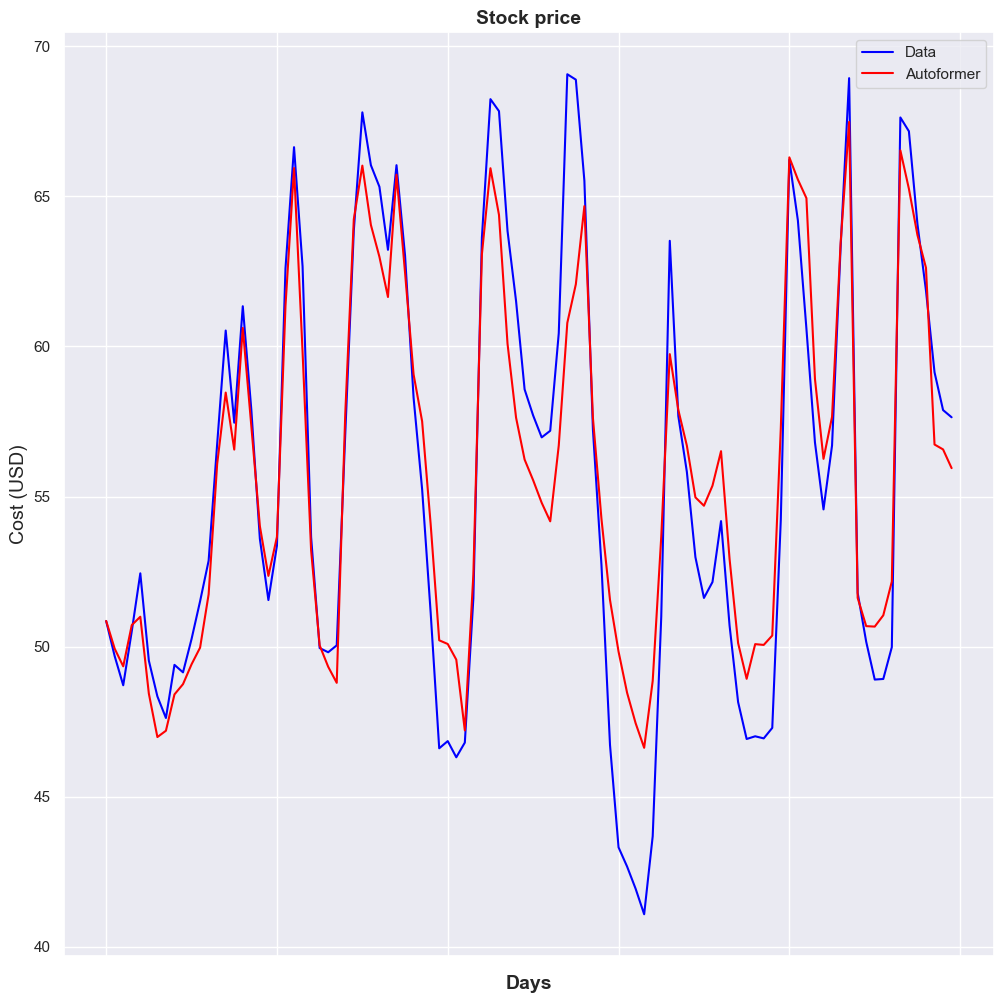

In [34]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = sns.lineplot(x = original.index, y = original[0], label="Ground Truth", color='blue')
ax = sns.lineplot(x = predict.index, y = predict_flattened.values.squeeze(), label="Autoformer", color='red')

ax.set_title('Energy Price Forecasting using Autoformer', size = 14, fontweight='bold')
ax.set_xlabel("Hours", size = 14, fontweight='bold')
ax.set_ylabel("Price", size = 14)
ax.set_xticklabels('', size=10)

In [35]:
criterion = nn.MSELoss(reduction='mean')
criterion(torch.tensor(original[0]).float(), torch.tensor(predict_flattened.values.squeeze()).float()), criterion(torch.tensor([1.0]), torch.tensor([1.0]))


(tensor(6.4816), tensor(0.))